This notebook includes the whole precedure building a logistic regression model, including:
### Step 1: Basic observations on the dataset
### Step 2: Split into training and testing datasets and normalize  features
- To avoid the individual bias and avoid the feature leakage, we randomly split videos into the training(80%) and testing dataset(20%)
  - We shuffle and randomly split the videos until the percentage of the paired investigation is comparable in both datasets
- To avoid order bias, we shuffle all investigation bouts within each dataset
- To avoid scaling bias, we apply Min-Max normalization on the training set and use the same transformation on the test set

### Step 3: Apply logistic regression
- Fit the model with L2 regularization to prevent overfitting
- Perform grid search over penalty values (10⁻⁴ to 10⁴) using mean 3-fold cross-validated accuracy for model selection

### Step 4: Evaluate the model
- Accuracy score: Proportion of correct predictions on the test set
- Cross-validation: 3-fold
- F1 score: To account for class imbalance

| Loading modules 

In [1]:
#import the neccessary python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
#import some useful functions from sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import mglearn
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#for tuning the random forest
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np


#for visualize the random forest model
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



import shap #for feature importance

#import some plotting packages
import seaborn as sns

#statistic comparison method
#because in our dataset, paired and non-paired investigations might be from the same video sequence, 
#we use the mixed effects model to do the statistic test in these two groups, using sequence_code as a fixed effect
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1: Basic observations on the dataset


1 | Load the preprocessed dat with hand-crafted features

,sequence,investigation_ID,pair_label,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
0,task1/train/mouse001_task1_annotator1,0,0_0,0,1,126,126,6.619949,3.681024,2.861946,0.047836
1,task1/train/mouse001_task1_annotator1,1,1_0,0,136,633,498,6.364444,3.583990,2.924218,0.041316
2,task1/train/mouse001_task1_annotator1,2,2_0,0,659,714,56,9.422267,5.151395,2.938320,0.045286
3,task1/train/mouse001_task1_annotator1,3,3_0,0,736,898,163,4.820933,3.456058,3.002670,0.039957
4,task1/train/mouse001_task1_annotator1,4,4_0,0,944,1045,102,2.838757,2.808712,2.714141,0.036523


,investigation_ID,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
count,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000
mean,29.082668,0.138590,6273.171587,6344.380688,72.209100,7.162941,4.765183,2.899996,0.053228
std,28.126639,0.345578,5144.694386,5132.128523,121.178995,4.923105,5.019670,0.134659,0.034554
min,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,2.020127,0.000000
25%,8.000000,0.000000,2023.000000,2089.000000,14.000000,4.040029,3.032544,2.841902,0.035343
50%,20.000000,0.000000,4972.000000,5037.000000,30.000000,6.041922,4.023517,2.925928,0.046019
75%,42.000000,0.000000,9629.500000,9698.500000,71.500000,8.935472,5.381169,2.994524,0.060868
max,155.000000,1.000000,23128.000000,23176.000000,1335.000000,110.985818,218.968631,3.136071,0.737952


sequence               0
investigation_ID       0
pair_label             0
paired                 0
start_frame            0
end_frame              0
duration               0
mean_speed             0
mean_acc               0
mean_rotation          0
mean_rotation_speed    0
dtype: int64


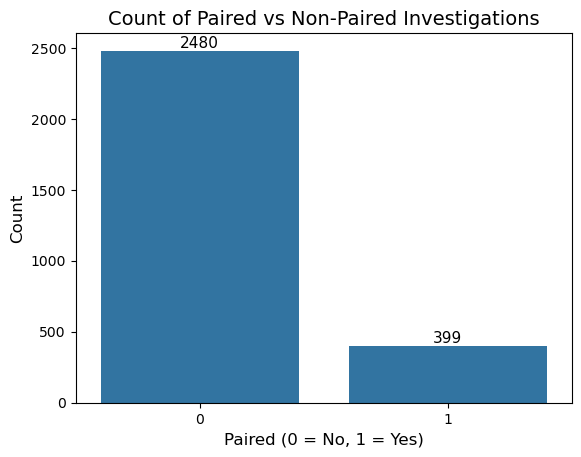

In [2]:
# Load your dataset (adjust path as needed)
df = pd.read_csv(r"G:\My Drive\100-PhD Study\110-Courses\2025Summer_Neuromatch\waffles\Waffle\preprocessed_data\final_df.csv")  # or df = your_dataframe

# Preview data
display(df.head())

# Summary statistics
display(df.describe())

# Check for missing values, just to make sure there's no missing data
print(df.isnull().sum())

# Show a bar plot reflecting the total number of 'paired investigation(1)' VS 'unpaired investigation(0)'
sns.countplot(data=df, x='paired')  
plt.title("Count of Paired vs Non-Paired Investigations", fontsize=14)
plt.xlabel("Paired (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Annotate the bars with counts
counts = df['paired'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=11)

plt.show()




##### We extracted 2879 investigation bouts from 88 videos, and (399/2879)13.9% of them are paired with a followed attack, which means the this is an imbalanced dataset with most investigations not immediately followed by an attack.

### Step 2: Split into training and testing datasets
1. GroupShuffleSplit the videos into the training(80%) and testing(20%) 
2. Shuffle the investigation bouts within a trianing set to avoid the order bias

In [3]:
print("Number of unique sequences:", df['sequence'].unique())
#note that 'task1/train/mouse036_task1_annotator1' was dropped after runnning find_I_A_all function the the preprecessed_label_feature notebook

Number of unique sequences: ['task1/train/mouse001_task1_annotator1'
 'task1/train/mouse002_task1_annotator1'
 'task1/train/mouse003_task1_annotator1'
 'task1/train/mouse004_task1_annotator1'
 'task1/train/mouse005_task1_annotator1'
 'task1/train/mouse006_task1_annotator1'
 'task1/train/mouse007_task1_annotator1'
 'task1/train/mouse008_task1_annotator1'
 'task1/train/mouse009_task1_annotator1'
 'task1/train/mouse010_task1_annotator1'
 'task1/train/mouse011_task1_annotator1'
 'task1/train/mouse012_task1_annotator1'
 'task1/train/mouse013_task1_annotator1'
 'task1/train/mouse014_task1_annotator1'
 'task1/train/mouse015_task1_annotator1'
 'task1/train/mouse016_task1_annotator1'
 'task1/train/mouse017_task1_annotator1'
 'task1/train/mouse018_task1_annotator1'
 'task1/train/mouse019_task1_annotator1'
 'task1/train/mouse020_task1_annotator1'
 'task1/train/mouse021_task1_annotator1'
 'task1/train/mouse022_task1_annotator1'
 'task1/train/mouse023_task1_annotator1'
 'task1/train/mouse024_task1_

In [4]:
#reencode the video ID to numbers
# Encode 'sequence' into numeric form 
df['sequence_code'] = pd.factorize(df['sequence'])[0]  # or 'video_id'


In [5]:
#drop the non-numeric information
non_numeric =['sequence', 'pair_label','start_frame','end_frame']
df_dropped = df.copy(deep=True)
df_dropped = df_dropped.drop(columns=non_numeric)

In [6]:
df_dropped

,investigation_ID,paired,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed,sequence_code
0,0,0,126,6.619949,3.681024,2.861946,0.047836,0
1,1,0,498,6.364444,3.583990,2.924218,0.041316,0
2,2,0,56,9.422267,5.151395,2.938320,0.045286,0
3,3,0,163,4.820933,3.456058,3.002670,0.039957,0
4,4,0,102,2.838757,2.808712,2.714141,0.036523,0
...,...,...,...,...,...,...,...,...
2874,42,0,6,2.615893,3.908312,3.126484,0.009456,87
2875,43,0,8,3.931406,2.945635,2.808574,0.045937,87
2876,44,0,13,1.449746,1.718144,2.936758,0.031133,87
2877,45,0,144,2.105103,2.130460,3.040754,0.018255,87


In [7]:
#try to write a function to split the dataset until the bouts and paired investigation percentage is similar in the trainig and testing dataset
best_diff = float('inf')
best_split = None

groups = df_dropped['sequence_code']  # 
labels = df_dropped['paired'].values

#search for a seed that result a comparable percentage of paired investigation in both datasets
for seed in range(1000):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed) #group shuffle split by the video sequence
    train_idx, test_idx = next(gss.split(df_dropped, labels, groups=groups))
    
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    
    train_pct = y_train.mean()
    test_pct = y_test.mean()
    
    diff = abs(train_pct - test_pct)
    
    if diff < best_diff:
        best_diff = diff
        best_split = (train_idx, test_idx)
        
    if diff < 0.01:  # stop early if sufficiently close
        break

train_idx, test_idx = best_split
df_train = df_dropped.iloc[train_idx].reset_index(drop=True)
df_test = df_dropped.iloc[test_idx].reset_index(drop=True)


In [8]:
print("random seed is: ",seed)

random seed is:  7


| Shuffle the investigation bouts within each dataset

In [9]:
#shuffle bouts in trianig set to avoid the order bias
df_train = df_train.sample(frac=1, random_state=42).reset_index()
x_train = df_train.drop(columns=['paired'])
y_train = df_train['paired']
#same shuffle in the testing dataset to void the order bias
df_test = df_test.sample(frac=1,random_state=42).reset_index()
x_test = df_test.drop(columns=['paired'])
y_test = df_test['paired']

| Check the training and testing datasets

1. check if the counts of the investigations from the same video are comparable

In [10]:
#show the counts of investigations from the same vdeo is comparable
x_train_counts = x_train.groupby('sequence_code').count()
x_test_counts = x_test.groupby('sequence_code').count() 

In [11]:
x_train_counts

,index,investigation_ID,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
sequence_code,,,,,,,
0,58,58,58,58,58,58,58
1,123,123,123,123,123,123,123
3,22,22,22,22,22,22,22
4,15,15,15,15,15,15,15
5,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...
83,47,47,47,47,47,47,47
84,20,20,20,20,20,20,20
85,39,39,39,39,39,39,39


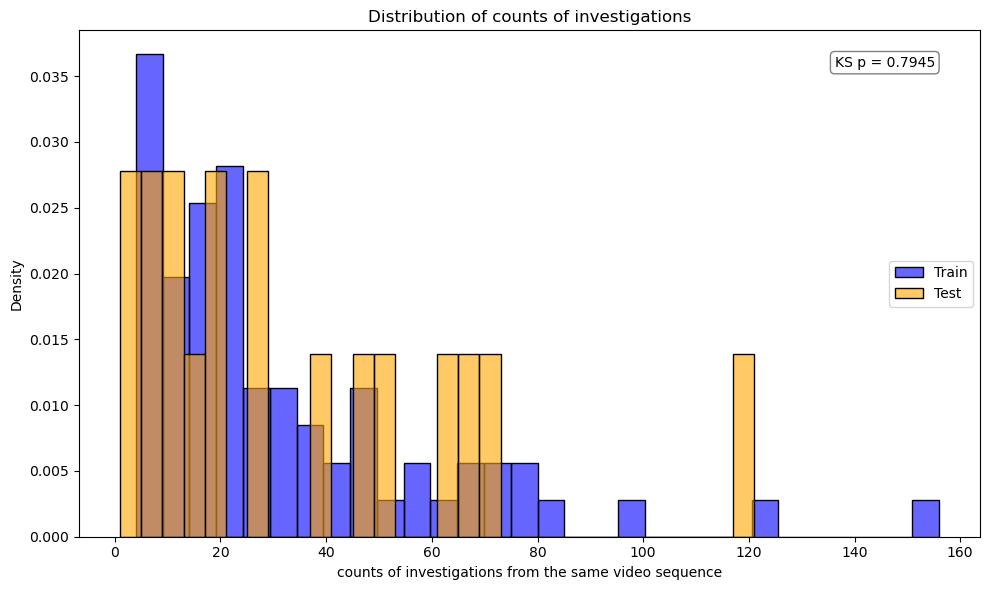

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(x_train_counts['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(x_test_counts['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(x_train_counts['investigation_ID'], x_test_counts['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Distribution of counts of investigations")
plt.xlabel("counts of investigations from the same video sequence")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


Another way to show this is to compare the distribution of 'investigation_ID' 

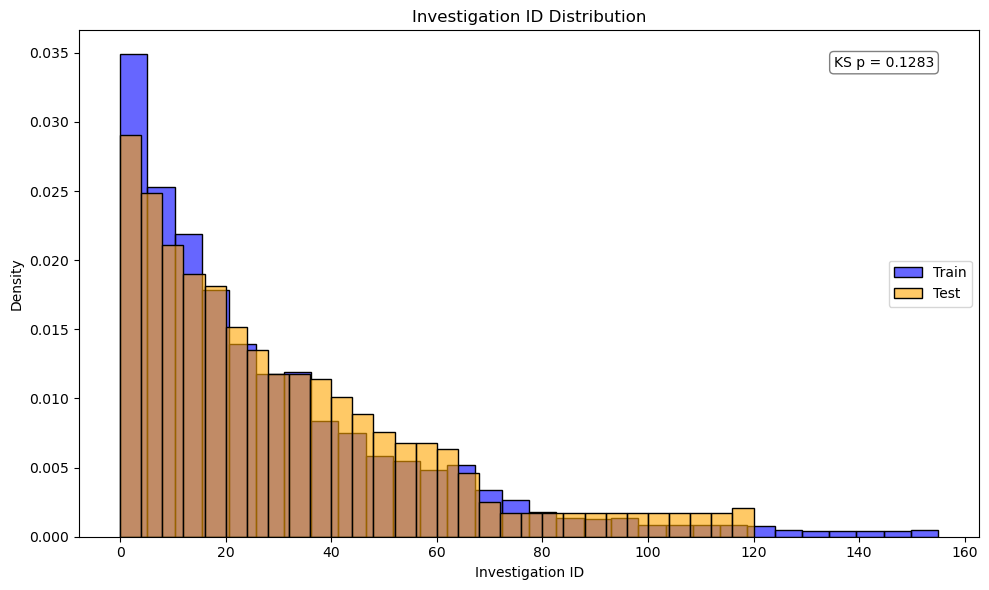

In [13]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_train['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(df_test['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(df_train['investigation_ID'], df_test['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Investigation ID Distribution")
plt.xlabel("Investigation ID")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


2. check if ther percentage of paired investigations are comparable 

C:\Users\sky\AppData\Local\Temp\ipykernel_20152\3036740146.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
C:\Users\sky\AppData\Local\Temp\ipykernel_20152\3036740146.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])


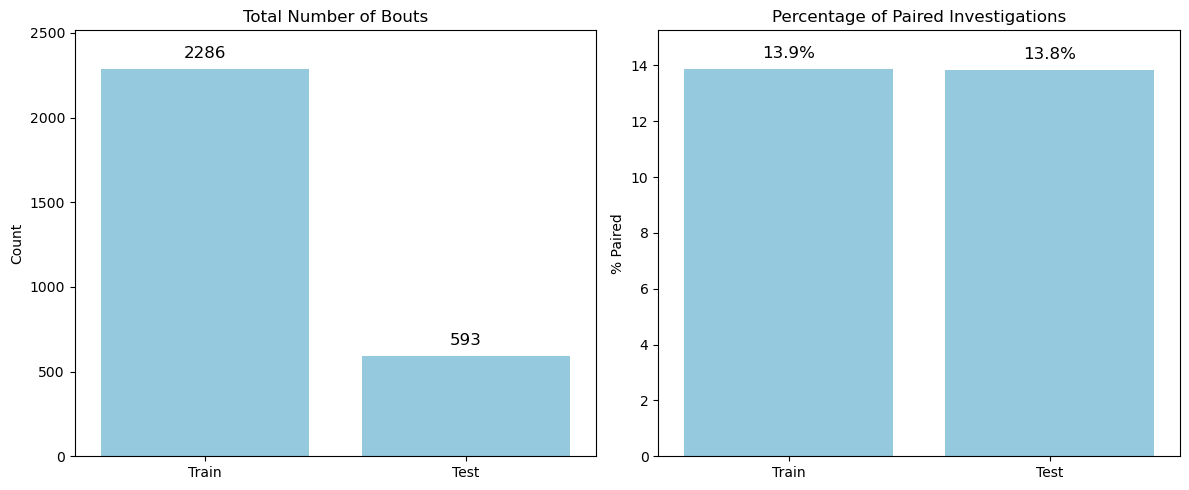

In [14]:

# Data
n_train = len(df_train)
n_test = len(df_test)

train_paired = df_train['paired'].sum()
test_paired = df_test['paired'].sum()

train_paired_pct = train_paired / n_train * 100
test_paired_pct = test_paired / n_test * 100

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ['skyblue', 'skyblue']

# 1. Total number of bouts
bouts_vals = [n_train, n_test]
sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
ax[0].set_title('Total Number of Bouts')
ax[0].set_ylabel('Count')

# Add value labels and adjust y-limit
max_bouts = max(bouts_vals)
for i, val in enumerate(bouts_vals):
    ax[0].text(i, val + max_bouts * 0.02, f'{val}', ha='center', va='bottom', fontsize=12)
ax[0].set_ylim(0, max_bouts * 1.10)

# 2. Percentage of paired investigations
paired_pct_vals = [train_paired_pct, test_paired_pct]
sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])
ax[1].set_title('Percentage of Paired Investigations')
ax[1].set_ylabel('% Paired')

max_pct = max(paired_pct_vals)
for i, val in enumerate(paired_pct_vals):
    ax[1].text(i, val + max_pct * 0.02, f'{val:.1f}%', ha='center', va='bottom', fontsize=12)
ax[1].set_ylim(0, max_pct * 1.10)

plt.tight_layout()
plt.show()


In [15]:
features = ["duration","mean_speed","mean_acc","mean_rotation","mean_rotation_speed"]
x_train_corr = x_train[features].corr(numeric_only=True)
x_test_corr = x_test[features].corr(numeric_only=True)

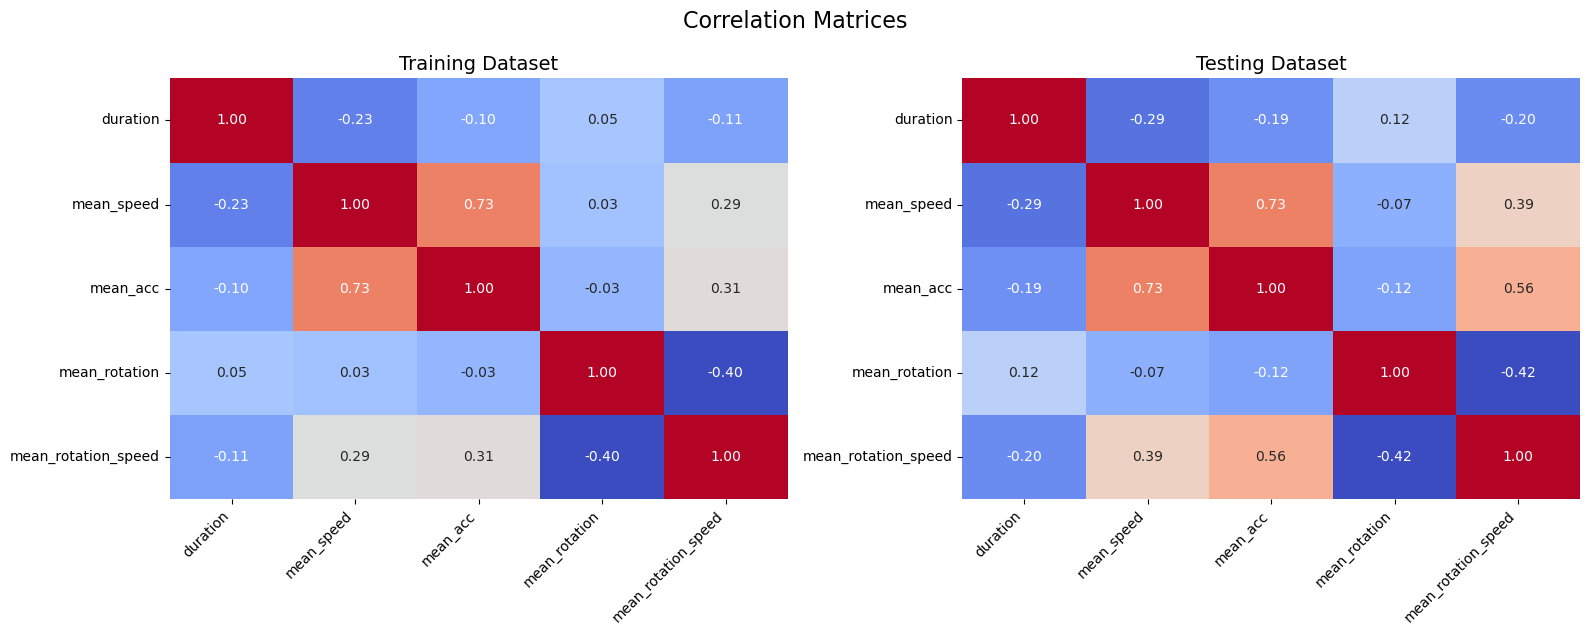

In [16]:

plt.figure(figsize=(16, 6))  # Wider figure for better spacing

# Training set correlation matrix
plt.subplot(1, 2, 1)
sns.heatmap(x_train_corr, annot=True, cmap='coolwarm', fmt=".2f", 
            cbar=False, annot_kws={"size": 10})
plt.title("Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Testing set correlation matrix
plt.subplot(1, 2, 2)
sns.heatmap(x_test_corr, annot=True, cmap='coolwarm', fmt=".2f", 
            cbar=False, annot_kws={"size": 10})
plt.title("Testing Dataset", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.suptitle("Correlation Matrices", fontsize=16, y=1.05)
plt.show()


combined with the correlation calculation, we found that in both dataset, mean speed and mean acceleration has 0.73 correlation

(Exploration)Are the handcrafted features are significantly different between the paired investigation VS non-paired investigation?
- Consider the mixed effect models, since the investigations from the same video might have their own bias

In [17]:
#merge the traininig dataset with label for violin plotting
x_train_violin = x_train.copy(deep=True)
x_train_violin["paired"] = y_train.values
x_test_violin = x_test.copy(deep=True)
x_test_violin["paired"] = y_test.values

#do the 

#violin plot for features by paired investigation VS non-paired investigation
features = ["duration","mean_speed","mean_acc","mean_rotation","mean_rotation_speed"]

| Check whether features are significantly different in paired VS non-paired investigations, and check whether the trend is preserved in both the training and testing datasets

In [18]:
#do the mixed effect test
mixed_results = {}
for feature in features:
    model_df = x_train_violin[[feature,'paired','sequence_code']].dropna()
    model_df['paired'] = model_df['paired'].astype('category')
    
    try:
        model = smf.mixedlm(f"{feature}~paired", model_df, groups=model_df["sequence_code"])
        result = model.fit()
        #T.1 mean "this is the treatment level corresponding to paired=1", so we view non-paired as the reference or basline
        pval = result.pvalues.get('paired[T.1]',None) #extract p for paired=1
        mixed_results[feature] = {
            'model':'feature ~ paired + (1 | sequence_code)',
            'pval':pval
        }
    except Exception as e:
        print(f'Could not fit model for {feature}: {e}')
        mixed_results[feature]={
            'model':'model failed',
            'pval': None
        }

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


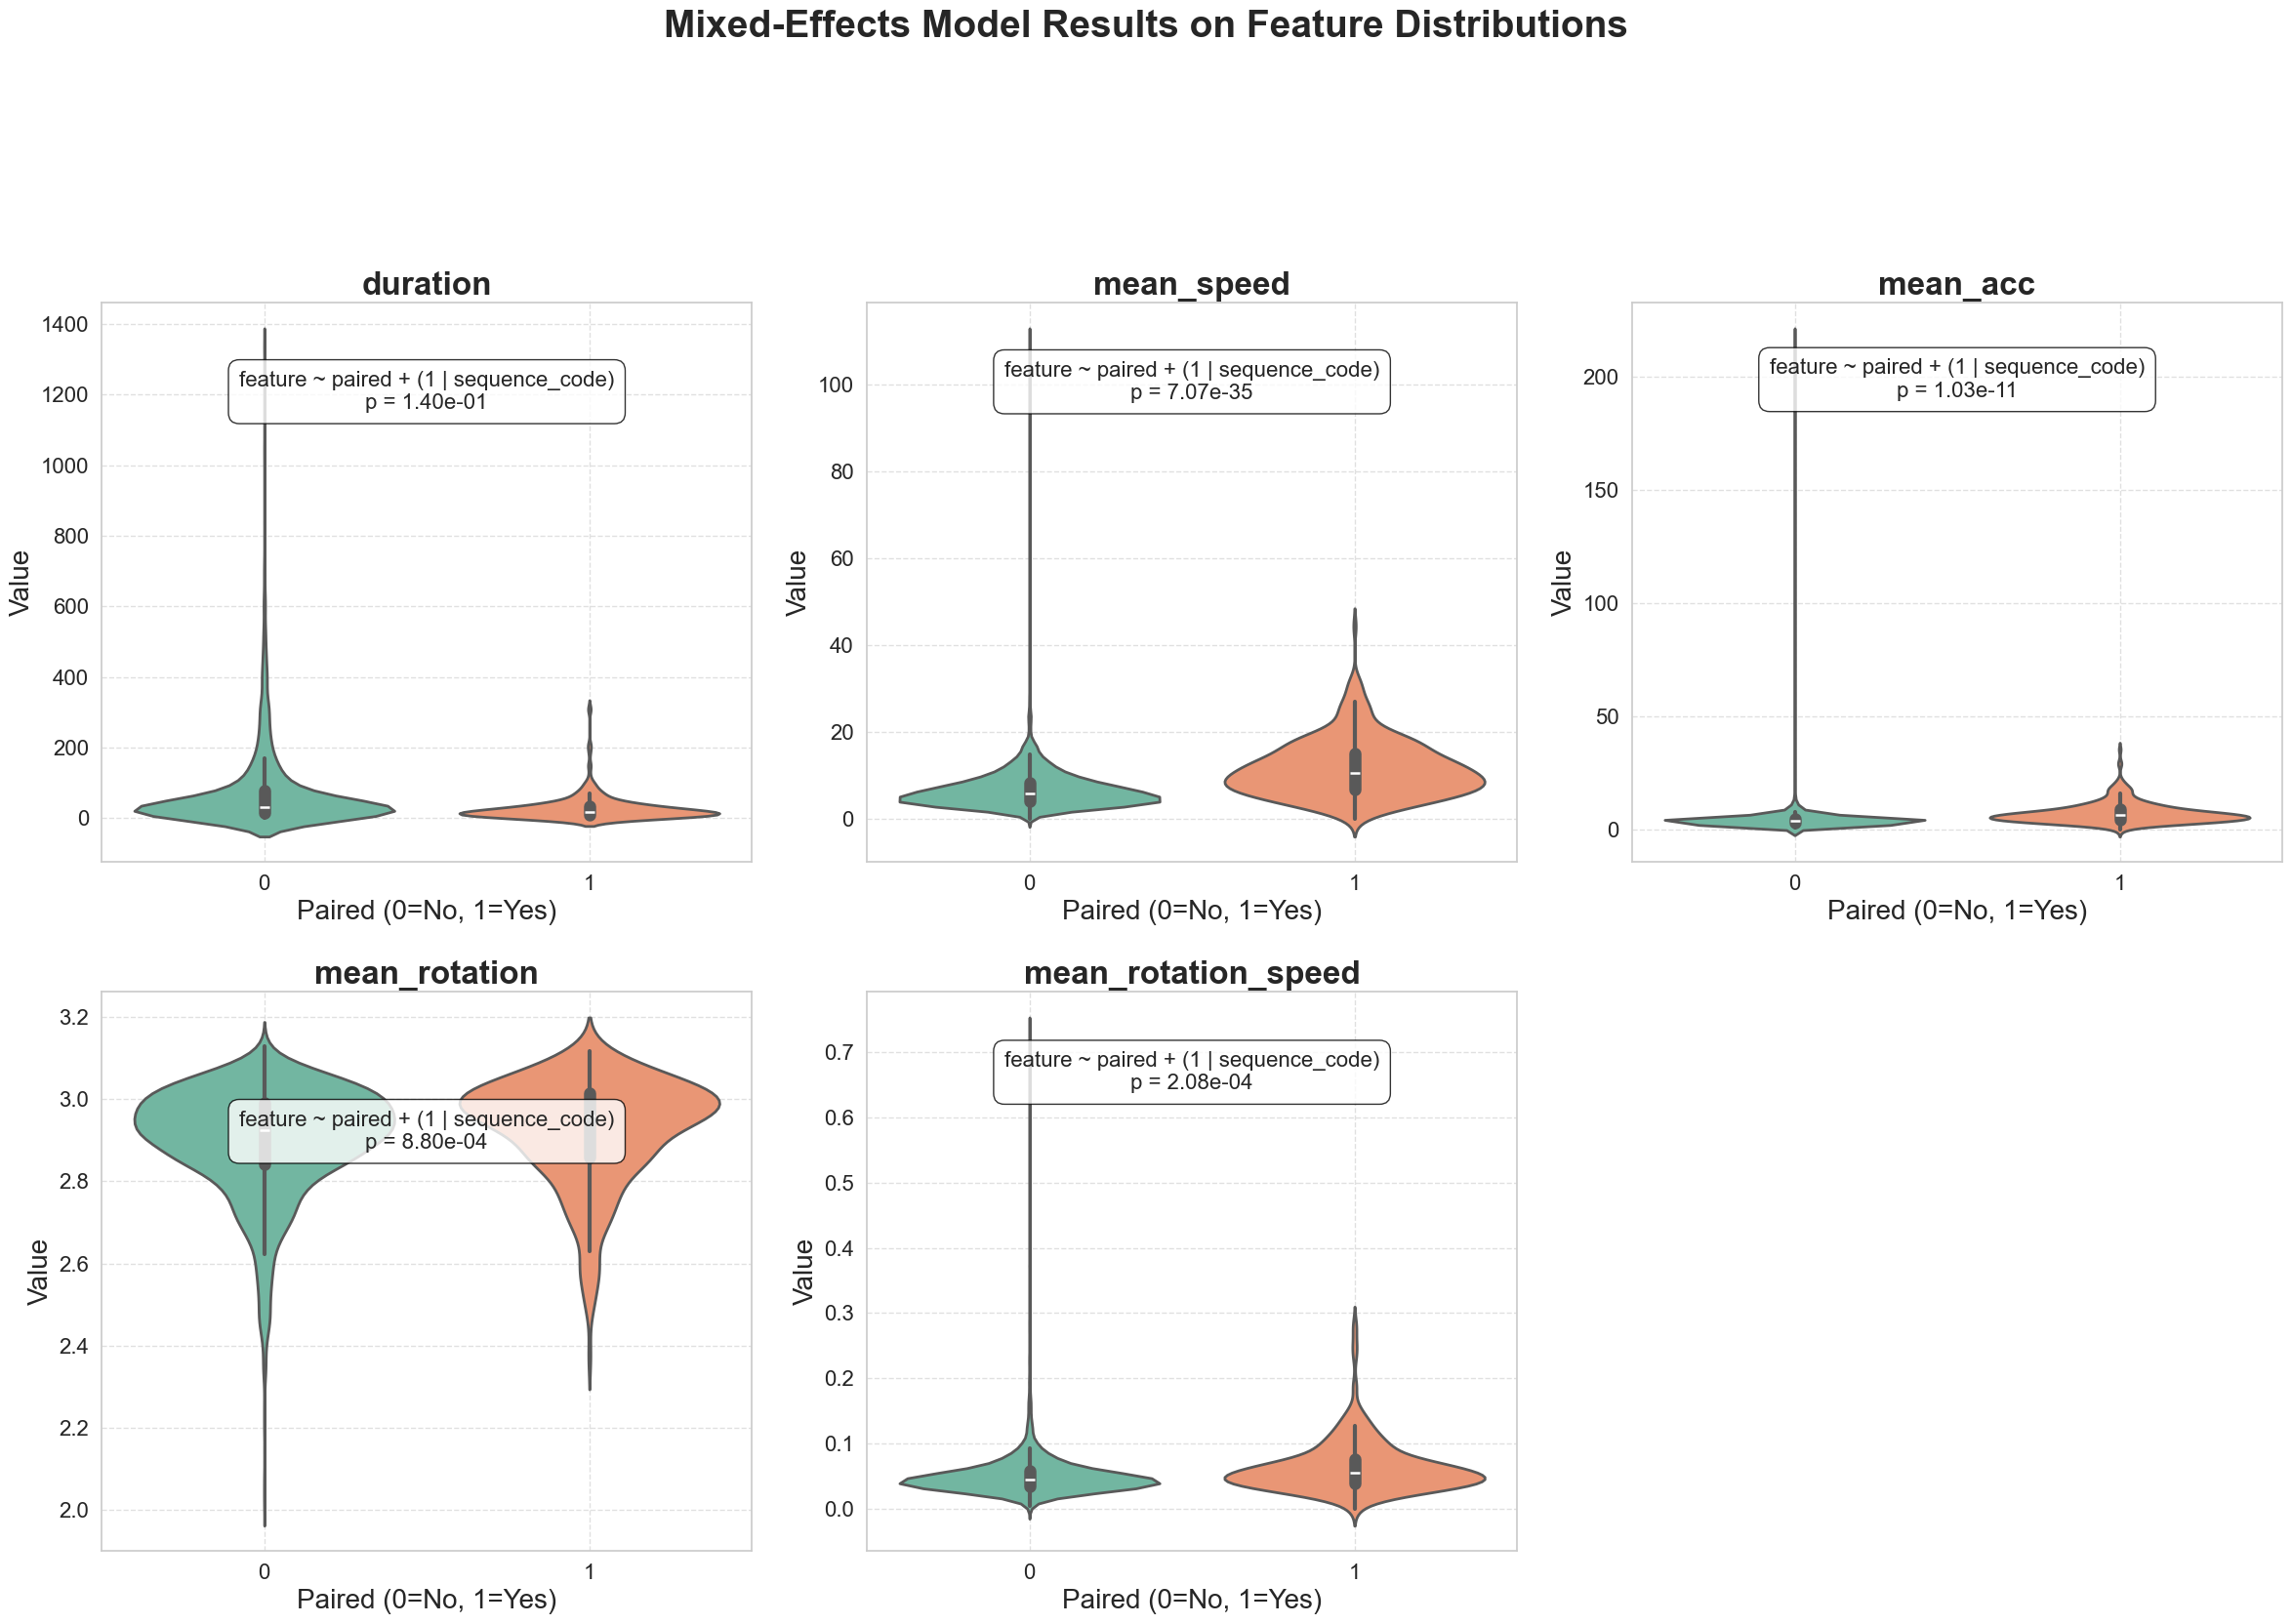

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style and font scale for big presentations
sns.set(style="whitegrid", font_scale=2)

# Initialize figure with large size
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)

    # Draw violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=x_train_violin,
        x='paired',
        y=feature,
        hue='paired',
        palette='Set2',
        density_norm='width',
        inner='box',
        linewidth=2,
        legend=False
    )

    # Set titles and labels in large fonts
    plt.title(f'{feature}', fontsize=24, fontweight='bold')
    plt.xlabel('Paired (0=No, 1=Yes)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add model annotation with larger font
    model_info = mixed_results.get(feature, {})
    model_text = model_info.get('model', 'model failed')
    pval = model_info.get('pval', None)
    annotation = f'{model_text}\np = {pval:.2e}' if pval is not None else f'{model_text}\np = N/A'

    # Put annotation slightly above max y
    y_max = x_train_violin[feature].max()
    plt.text(
        0.5,
        y_max * 0.95,
        annotation,
        ha='center',
        va='top',
        fontsize=16,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5')
    )

# Super title
plt.suptitle('Mixed-Effects Model Results on Feature Distributions', fontsize=28, fontweight='bold', y=1.05)

# Fix layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


- We can see that mean speed, mean acceleration, mean rotation angle, and mean rotation speed are significantly different between the paired investigations and non-paired investigations

(exploration)Can we see similar statistic difference in test dataset

In [20]:
# do the same test for the test dataset
#do the mixed effect test
mixed_results = {}
for feature in features:
    model_df = x_test_violin[[feature,'paired','sequence_code']].dropna()
    model_df['paired'] = model_df['paired'].astype('category')
    
    try:
        model = smf.mixedlm(f"{feature}~paired", model_df, groups=model_df["sequence_code"])
        result = model.fit()
        #T.1 mean "this is the treatment level corresponding to paired=1", so we view non-paired as the reference or basline
        pval = result.pvalues.get('paired[T.1]',None) #extract p for paired=1
        mixed_results[feature] = {
            'model':'feature ~ paired + (1 | sequence_code)',
            'pval':pval
        }
    except Exception as e:
        print(f'Could not fit model for {feature}: {e}')
        mixed_results[feature]={
            'model':'model failed',
            'pval': None
        }

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

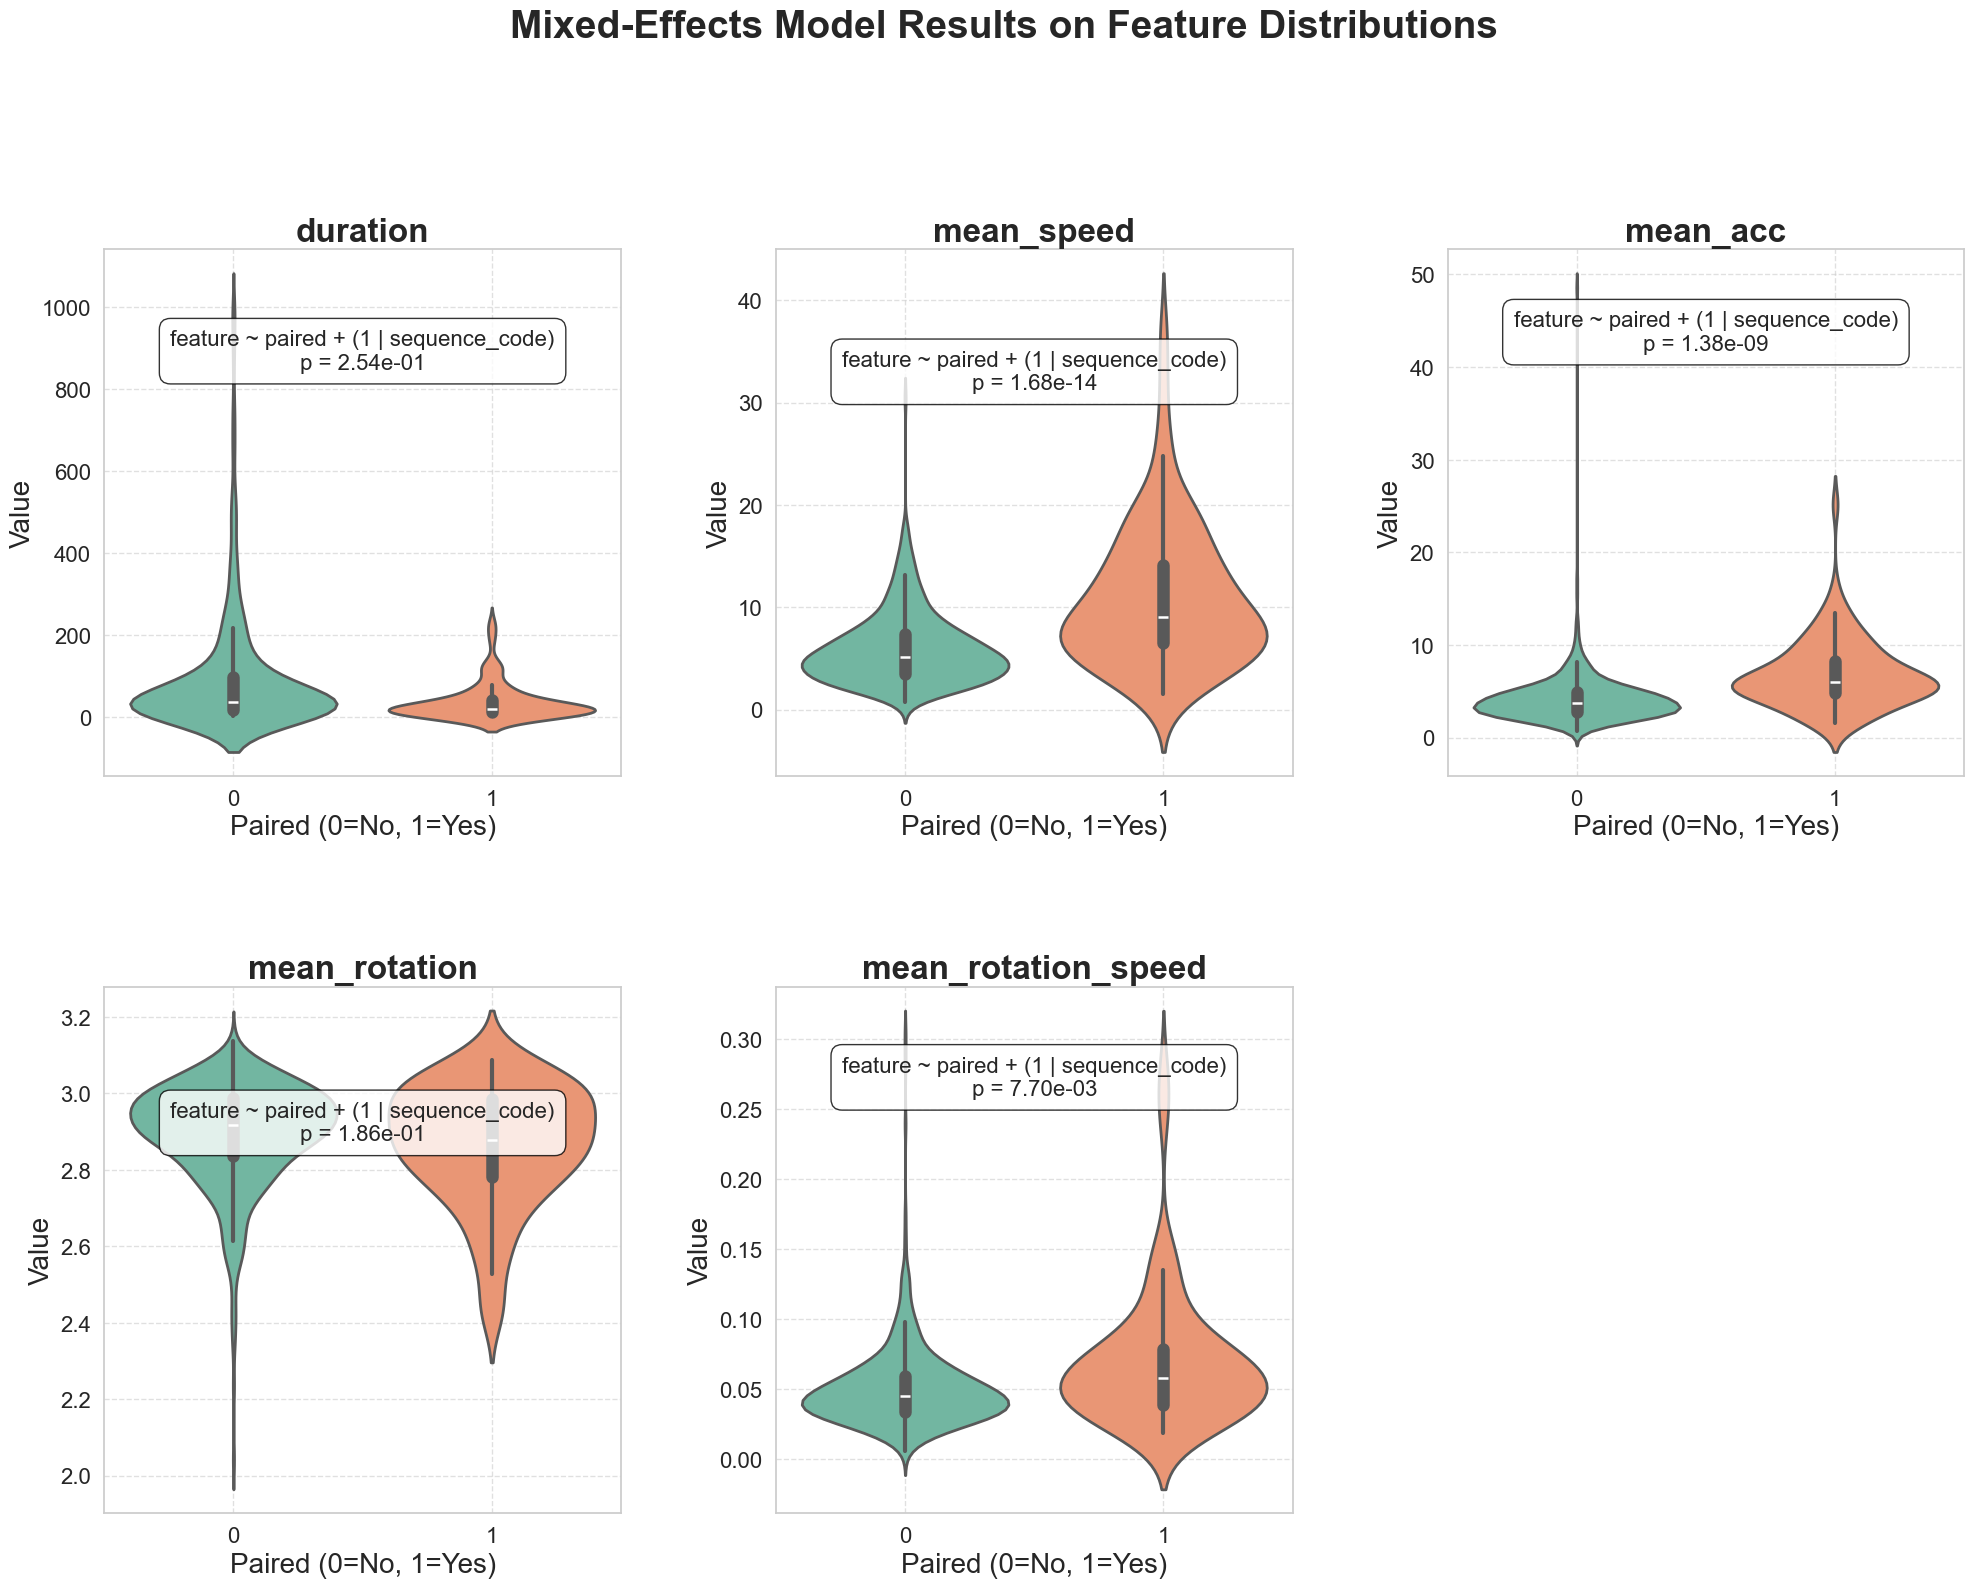

In [21]:

# Set global style and font scale for big presentations
sns.set(style="whitegrid", font_scale=2)

# Initialize figure with large size
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)

    # Draw violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=x_test_violin,
        x='paired',
        y=feature,
        hue='paired',
        palette='Set2',
        density_norm='width',
        inner='box',
        linewidth=2,
        legend=False
    )

    # Set titles and labels in large fonts
    plt.title(f'{feature}', fontsize=24, fontweight='bold')
    plt.xlabel('Paired (0=No, 1=Yes)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add model annotation with larger font
    model_info = mixed_results.get(feature, {})
    model_text = model_info.get('model', 'model failed')
    pval = model_info.get('pval', None)
    annotation = f'{model_text}\np = {pval:.2e}' if pval is not None else f'{model_text}\np = N/A'

    # Put annotation slightly above max y
    y_max = x_test_violin[feature].max()
    plt.text(
        0.5,
        y_max * 0.95,
        annotation,
        ha='center',
        va='top',
        fontsize=16,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5')
    )

# Super title
plt.suptitle('Mixed-Effects Model Results on Feature Distributions', fontsize=28, fontweight='bold', y=1.05)

# Fix layout
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

plt.show()


- From the mixed effect model, the mean rotation angle is not significantly different, so we expect to see a decrease of prediction accuracy if the model relys heavily on the mean rotation

## Apply MinMaxScaler to normalize the features

In [22]:
#normalize the features to avoid the learned weight bias
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) #remember to fit the same transformation to the test datset

In [23]:
# Convert back to DataFrames
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns).reset_index(drop=True)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns).reset_index(drop=True)#drop the index column

(Exploration) Check the distribution and correlation of features

| plot the scatter_matrix to :
1. Visualize pairwise relationships between all features
2. Check correlations or patterns among features
3. Spot outliers or clusters
4. Use color (c) to reflect class labels, e.g. y_train

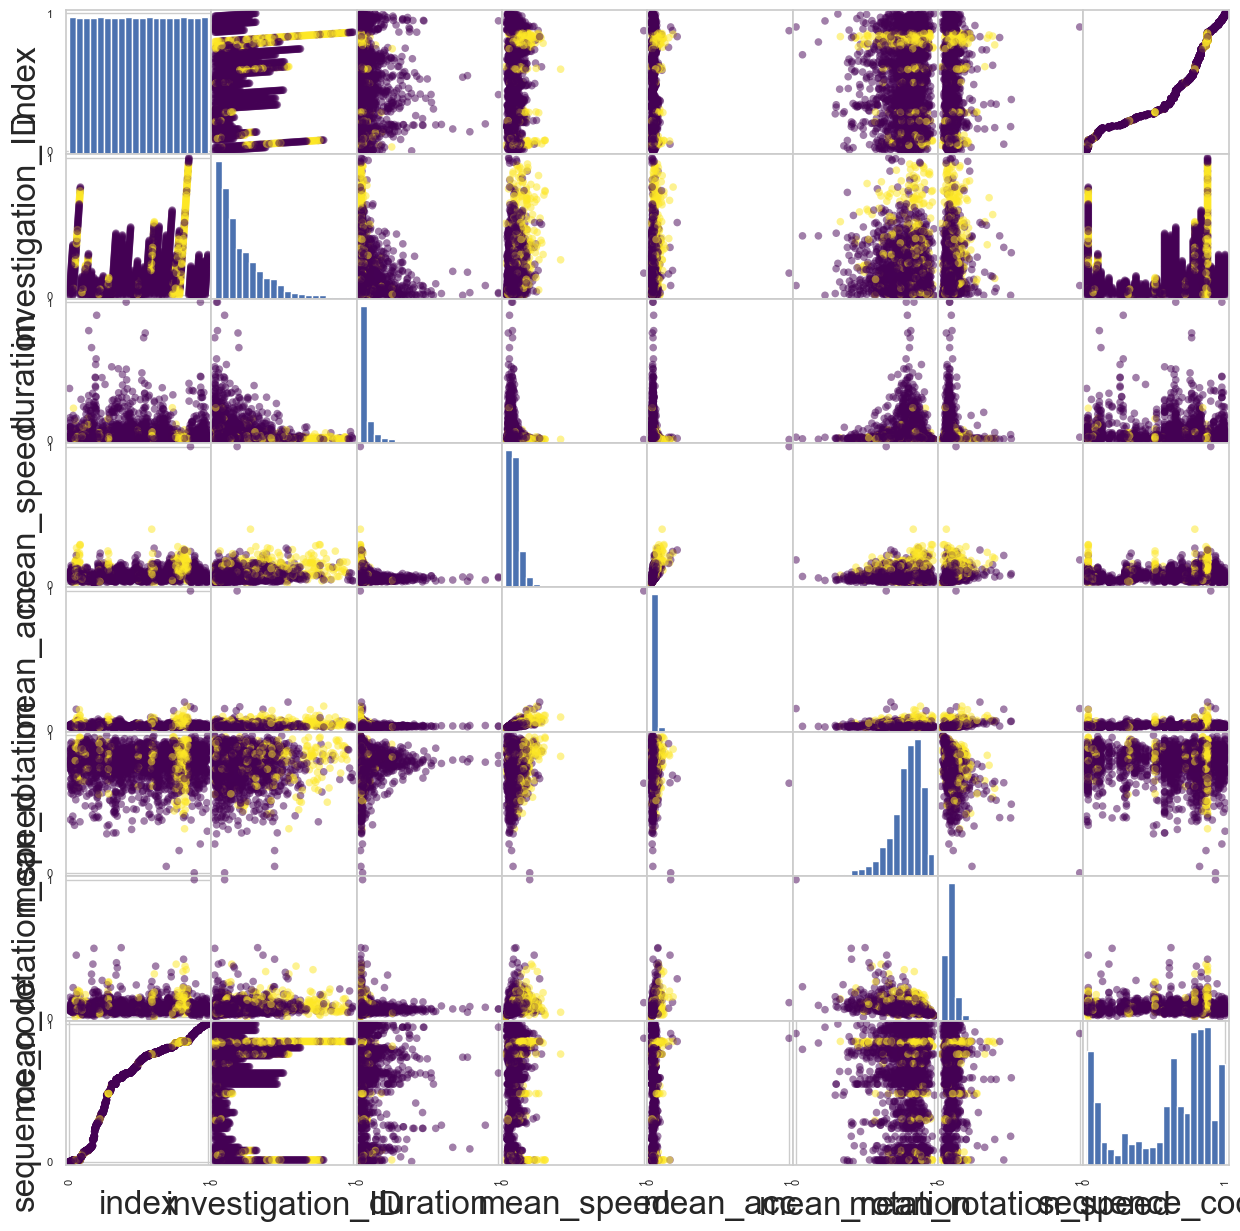

In [24]:
#check the correlation between each features, a good feature selection should avoid the correlation
import matplotlib.pyplot as plt
import pandas as pd

grr = pd.plotting.scatter_matrix(
    x_train_scaled,
    c=y_train,
    figsize=(15, 15),
    marker='o',
    hist_kwds={'bins': 20},
    s=30,
    alpha=0.5,
    diagonal='hist',
    cmap='viridis'  # or 'viridis', 'coolwarm', 'inferno', etc.
)


### Step 3: Apply logistic regression + Step 4: Model evaluation

In [25]:
#before applying the model, drop the investigation_ID and sequence_code
non_related = ['investigation_ID', 'sequence_code','index']
x_train_scaled_final = x_train_scaled.copy(deep=True)
x_test_scaled_final = x_test_scaled.copy(deep=True)
x_train_scaled_final = x_train_scaled_final.drop(columns = non_related)
x_test_scaled_final = x_test_scaled_final.drop(columns = non_related)

1. Logistic regression without penalizing misclassifying the minority class more

In [58]:
#apply the logistic regression
# Logistic Regression with GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Inverse of regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Suitable for L2, saga for l1
    'max_iter': [1000],
}

logreg_nonbalanced = LogisticRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #use this to preserve the percentages of paired or not paired samples are comparable

grid_search = GridSearchCV(logreg_nonbalanced, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train_scaled_final, y_train)

# Best model
best_model_nonbalanced = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 166.81005372000558, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Test Accuracy: 0.8786
F1 Score: 0.2340
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       511
           1       0.92      0.13      0.23        82

    accuracy                           0.88       593
   macro avg       0.90      0.57      0.58       593
weighted avg       0.88      0.88      0.84       593



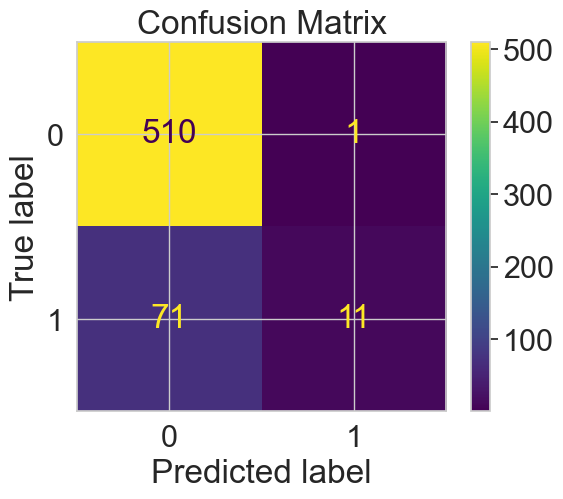

In [59]:
# Predict on test set
y_pred = best_model_nonbalanced.predict(x_test_scaled_final)

# Accuracy
acc_unbalanced = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_unbalanced:.4f}")

# F1 Score
f1_unbalanced = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_unbalanced:.4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model_nonbalanced, x_test_scaled_final, y_test)
plt.title("Confusion Matrix")
plt.show()


2. Logistic regression with penalizing misclassifying the minority class more

In [51]:
#apply the logistic regression
# Logistic Regression with GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Inverse of regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Suitable for L2, saga for l1
    'max_iter': [1000],
    'class_weight':['balanced'] #penalize misclassifying the minority class more
}

logreg_balanced = LogisticRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #use this to preserve the percentages of paired or not paired samples are comparable

grid_search = GridSearchCV(logreg_balanced, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train_scaled_final, y_train)

# Best model
best_model_balanced = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 1291.5496650148827, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Test Accuracy: 0.7622
F1 Score: 0.4051
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       511
           1       0.31      0.59      0.41        82

    accuracy                           0.76       593
   macro avg       0.62      0.69      0.63       593
weighted avg       0.84      0.76      0.79       593



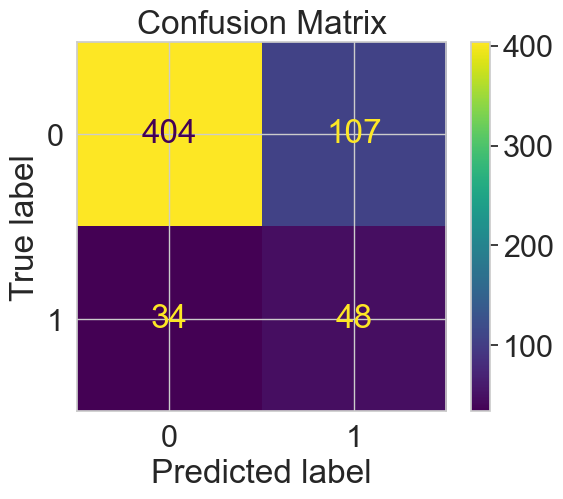

In [52]:
# Predict on test set
y_pred = best_model_balanced.predict(x_test_scaled_final)

# Accuracy
acc_balanced = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_balanced:.4f}")

# F1 Score
f1_balanced = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_balanced:.4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model_balanced, x_test_scaled_final, y_test)
plt.title("Confusion Matrix")
plt.show()


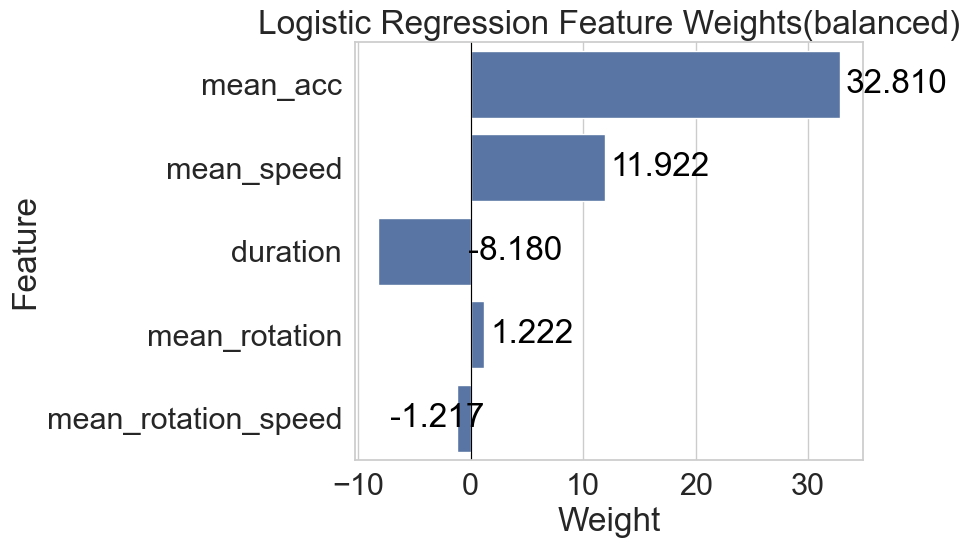

In [53]:
#visualize the coefficient

# Get feature names
feature_names = x_train_scaled_final.columns

# Get model coefficients (for binary classification, this is 1D)
coefs = best_model_balanced.coef_[0]

# Create a DataFrame for better plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefs
}).sort_values(by='Weight', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df)
plt.axvline(0, color='black', linewidth=0.8)

for i, (weight, feature) in enumerate(zip(coef_df['Weight'], coef_df['Feature'])):
    if weight > 0:
        plt.text(weight + 0.5, i, f"{weight:.3f}", va='center', ha='left', color='black')
    else:
        plt.text(weight + 2 * abs(weight), i, f"{weight:.3f}", va='center', ha='right', color='black')

plt.title('Logistic Regression Feature Weights(balanced)')
plt.tight_layout()
plt.show()



Try searching from a wider range of hyperparameters using hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

def tune_logistic_regression(X_train, y_train, max_evals=50, random_state=42):
    """
    Hyperparameter tuning for logistic regression using Hyperopt.
    """

    # Search space (penalty and solver are now strings directly)
    param_space = {
        'C': hp.loguniform('C', -4, 4),  # log-uniform between e^-4 and e^2
        'penalty': hp.choice('penalty', ['l1', 'l2']),
        'solver': hp.choice('solver', ['liblinear', 'saga', 'lbfgs']), #lbfgs means limited-memory BFGs optimization algorithm
        'class_weight': hp.choice('class_weight', [None, 'balanced'])
    }

    def objective(params):
        # Validate combination
        if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
            return {'loss': float('inf'), 'status': STATUS_OK}
        if params['penalty'] == 'l2' and params['solver'] not in ['lbfgs', 'liblinear', 'sag', 'saga']:
            return {'loss': float('inf'), 'status': STATUS_OK}

        clf = LogisticRegression(
            C=params['C'],
            penalty=params['penalty'],
            solver=params['solver'],
            class_weight=params['class_weight'],
            max_iter=1000
        )

        f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
        return {'loss': -f1, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(random_state)
    )

    # Get actual values (no need to decode anything)
    best_params = {
        'C': best['C'],
        'penalty': ['l1', 'l2'][best['penalty']],
        'solver': ['liblinear', 'saga'][best['solver']],
        'class_weight': [None, 'balanced'][best['class_weight']]
    }

    best_model = LogisticRegression(
        **best_params,
        max_iter=1000
    )
    best_model.fit(X_train, y_train)

    return best_model, best_params, trials


In [61]:
best_model_hy, best_params_hy, trials = tune_logistic_regression(x_train_scaled_final, y_train)

# Predict and evaluate
y_pred = best_model_hy.predict(x_test_scaled_final)
# Accuracy
acc_hy_LR = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc_balanced:.4f}")

# F1 Score
f1_hy_LR = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_balanced:.4f}")


print("Classification Report:\n", classification_report(y_test, y_pred))


100%|██████████| 50/50 [00:03<00:00, 13.69trial/s, best loss: -0.4267392662307793] 
Test Accuracy: 0.7622
F1 Score: 0.4051
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       511
           1       0.31      0.59      0.41        82

    accuracy                           0.76       593
   macro avg       0.62      0.69      0.63       593
weighted avg       0.84      0.76      0.79       593



In [33]:
print(best_params_hy)

{'C': 23.128815946581405, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'}


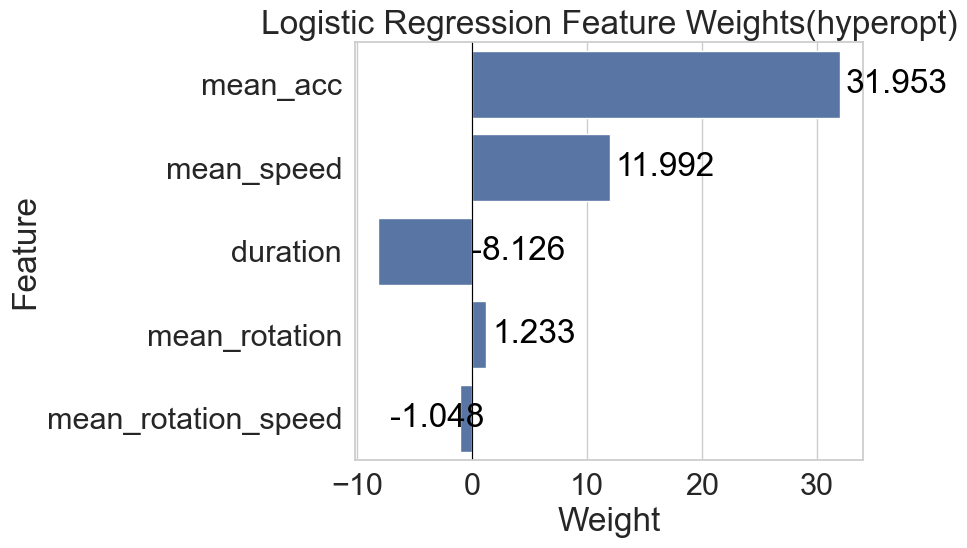

In [54]:
coefs = best_model_hy.coef_[0]
# Create a DataFrame for better plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefs
}).sort_values(by='Weight', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df)
plt.axvline(0, color='black', linewidth=0.8)

for i, (weight, feature) in enumerate(zip(coef_df['Weight'], coef_df['Feature'])):
    if weight > 0:
        plt.text(weight + 0.5, i, f"{weight:.3f}", va='center', ha='left', color='black')
    else:
        plt.text(weight + 2 * abs(weight), i, f"{weight:.3f}", va='center', ha='right', color='black')

plt.title('Logistic Regression Feature Weights(hyperopt)')
plt.tight_layout()
plt.show()


Tune a random forest model

In [40]:

def tune_random_forest(
    X_train, 
    y_train, 
    max_evals=50, 
    random_state=42, 
    scoring='f1'
):
    """
    Hyperparameter tuning for RandomForestClassifier using Hyperopt.

    Parameters
    ----------
    X_train : array-like, shape (n_samples, n_features)
        Training data.
    y_train : array-like, shape (n_samples,)
        Target values.
    max_evals : int, default=50
        Number of hyperopt evaluations.
    random_state : int, default=42
        Random seed.
    scoring : str, default='f1'
        Scoring metric for cross_val_score.

    Returns
    -------
    best_model : RandomForestClassifier
        RandomForestClassifier refit on the entire training data with best params.
    best_params : dict
        The best hyperparameter configuration found.
    trials : hyperopt.Trials
        The Trials object, containing the full search history.
    """

    # Define the Hyperopt search space
    param_space = {
        'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
        'max_depth': hp.choice('max_depth', [None] + list(range(5, 31, 5))),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.choice('max_features', [ 'sqrt', 'log2', None]),
        'bootstrap': hp.choice('bootstrap', [True, False]),
        'criterion': hp.choice('criterion', ['gini', 'entropy']),
        'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample'])
    }

    def objective(params):
        # Cast the integers back from floats
        params['n_estimators'] = int(params['n_estimators'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['min_samples_leaf'] = int(params['min_samples_leaf'])

        clf = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            bootstrap=params['bootstrap'],
            criterion=params['criterion'],
            class_weight=params['class_weight'],
            random_state=random_state,
            n_jobs=-1
        )

        # We negate because Hyperopt minimizes the objective
        score = cross_val_score(clf, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(random_state)
    )

    # Define options for decoding categorical choices
    max_depth_options = [None] + list(range(5, 31, 5))
    max_features_options = ['sqrt', 'log2', None]
    bootstrap_options = [True, False]
    criterion_options = ['gini', 'entropy']
    class_weight_options = [None, 'balanced', 'balanced_subsample']

    # Convert best indices back to real values
    best_params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': max_depth_options[best['max_depth']],
        'min_samples_split': int(best['min_samples_split']),
        'min_samples_leaf': int(best['min_samples_leaf']),
        'max_features': max_features_options[best['max_features']],
        'bootstrap': bootstrap_options[best['bootstrap']],
        'criterion': criterion_options[best['criterion']],
        'class_weight': class_weight_options[best['class_weight']],
        'random_state': random_state,
        'n_jobs': -1
    }


    # Refit on the full training data
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train, y_train)

    return best_model, best_params, trials


In [ ]:
best_model_rf, best_params_rf, trials = tune_random_forest(x_train_scaled_final, y_train)

# Predict and evaluate
y_pred = best_model_rf.predict(x_test_scaled_final)
print("F1 Score:", f1_score(y_test, y_pred))
# Accuracy
acc_hy_RF = accuracy_score(y_test, y_pred)


# F1 Score
f1_hy_RF = f1_score(y_test, y_pred)



print("Classification Report:\n", classification_report(y_test, y_pred))



100%|██████████| 50/50 [03:33<00:00,  4.27s/trial, best loss: -0.4614243013500034] 
F1 Score: 0.4311377245508982
Test Accuracy: 0.7622
F1 Score: 0.4051
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       511
           1       0.42      0.44      0.43        82

    accuracy                           0.84       593
   macro avg       0.67      0.67      0.67       593
weighted avg       0.84      0.84      0.84       593



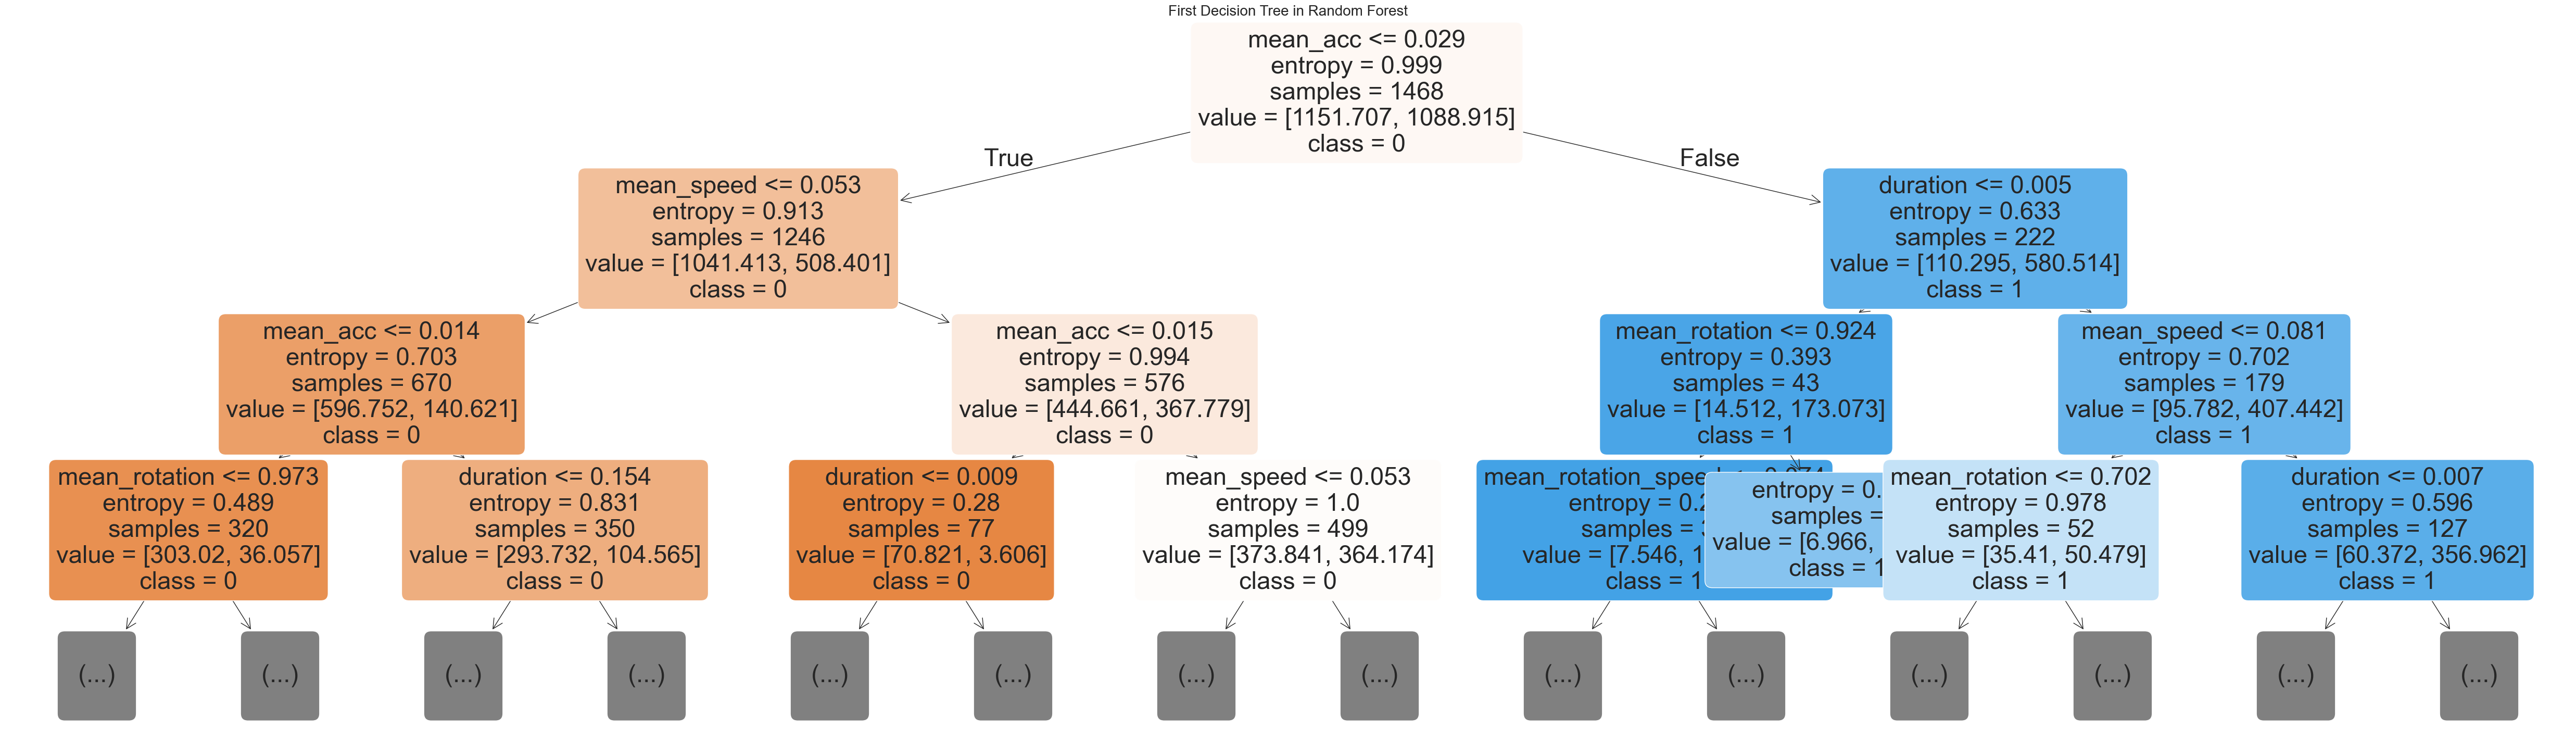

In [48]:

# Get the first decision tree from the forest
estimator = best_model_rf.estimators_[0]

plt.figure(figsize=(50, 15))  # Increase overall size
plot_tree(estimator, 
          feature_names=x_train_scaled_final.columns, 
          class_names=[str(cls) for cls in best_model_rf.classes_],
          filled=True, 
          rounded=True, 
          max_depth=3,          # Optional: limit depth for clarity
          fontsize=34)          # 👈 Make text much larger
plt.title("First Decision Tree in Random Forest", fontsize=20)
plt.tight_layout()
plt.show()

C:\Users\sky\AppData\Local\Temp\ipykernel_20152\406581557.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette="viridis")


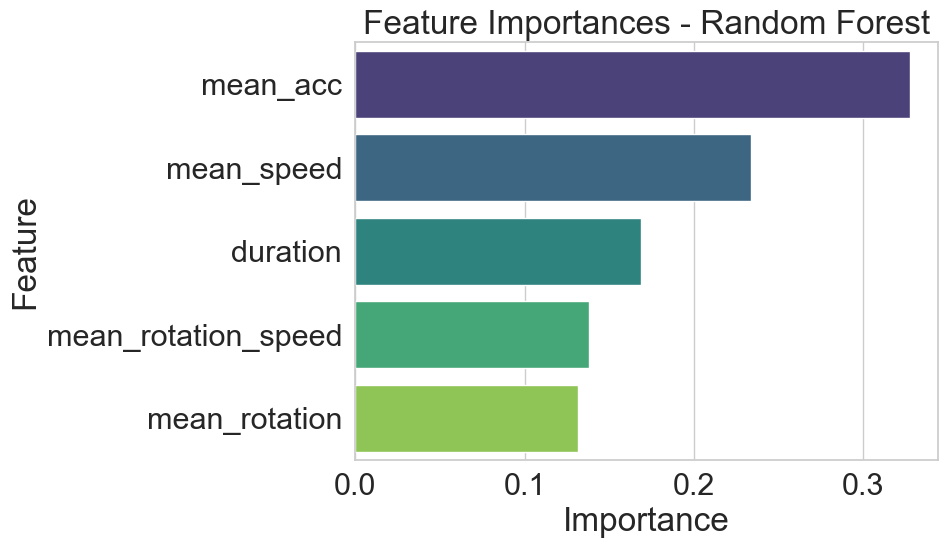

In [49]:

importances = best_model_rf.feature_importances_
features = x_train_scaled_final.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette="viridis")
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


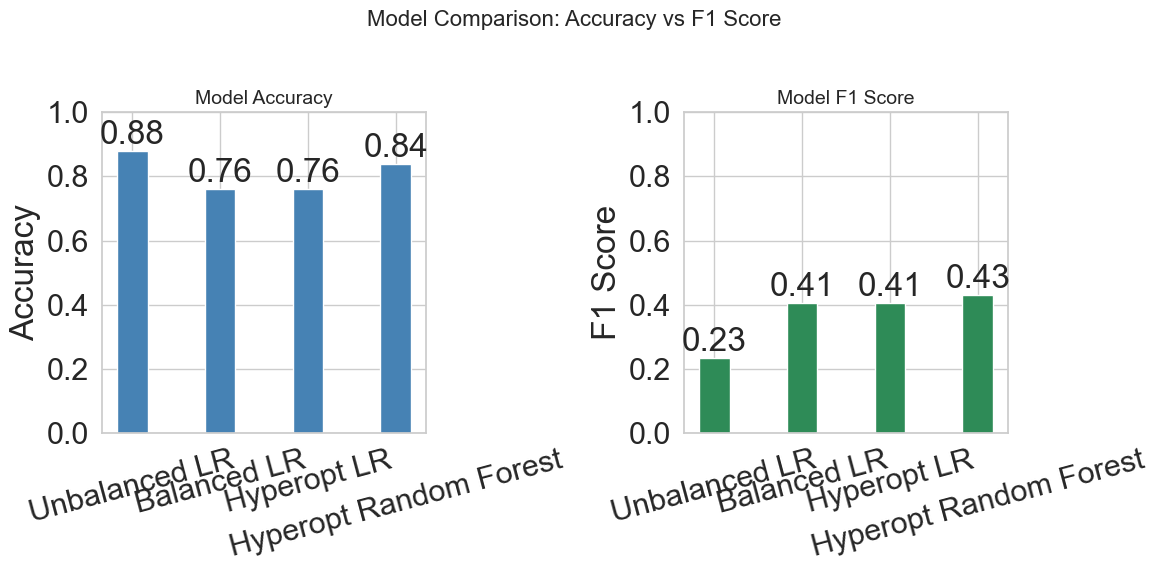

In [67]:
# Labels and values
models = ['Unbalanced LR', 'Balanced LR','Hyperopt LR', 'Hyperopt Random Forest']
accuracy = [acc_unbalanced, acc_balanced, acc_hy_LR,acc_hy_RF]
f1_scores = [f1_unbalanced, f1_balanced, f1_hy_LR,f1_hy_RF]

x = np.arange(len(models))  # [0, 1, 2]
width = 0.35  # Width of the bars

# Create subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axs[0].bar(x, accuracy, width, color='steelblue')
axs[0].set_title('Model Accuracy', fontsize=14)
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=15)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Accuracy')
axs[0].bar_label(axs[0].containers[0], fmt='%.2f')

# Plot F1 score
axs[1].bar(x, f1_scores, width, color='seagreen')
axs[1].set_title('Model F1 Score', fontsize=14)
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=15)
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('F1 Score')
axs[1].bar_label(axs[1].containers[0], fmt='%.2f')

# Layout adjustments
plt.suptitle('Model Comparison: Accuracy vs F1 Score', fontsize=16)
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
plt.show()

### Conclusion


1. The accuracy for the paired investigation is not high, so the model learns larger weights to predict the non-paired investigation

In [ ]:
#future direction: random forest

### Supplement Notes

1. Hyperopt: a python library for hyperparameter optimization using advanced algorithms rather than hard grid search
   1. Step1: define the search space, create a disctionary, each key specify the tuned hyperparameters, and the value is the searched value space.
      1. for example: for random forest, you can tune the max_depth, max_features and so on
   2. Step2: define the objectives including building a model and run the validation and defining the 'loss' function to evaluate the tuned model
   3. Step3: run the search, choose max_evals
   4. Step4:choose the optimal model, evaluate the model